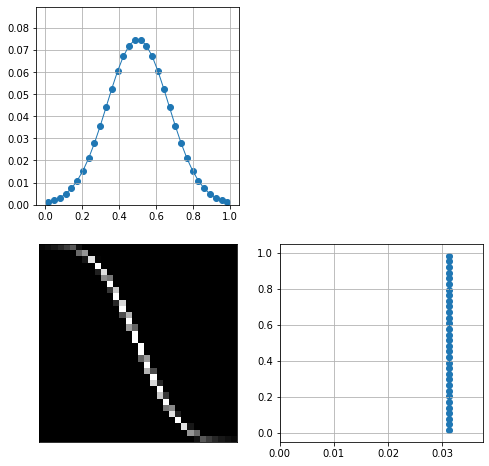

In [99]:
#
# Transport of distribtution
#

#
# [ Monge-Kantorovich problem ]
#
# Given
# - p > 0 \in R^{m}
# - q > 0 \in R^{n}
# - D \in R^{n x m}
#
# Find 
# - F > 0 \in R^{n x m} s.t.
#   - minimize sum_{i, j} F_{i, j} D_{i, j}
#   - (1, .., 1) F = p^Tp = q
#   - F (1,..,1)^T = q
#
#
# [ Linear programming ]
# 
# Given
# - A \in R^{k x l}
# - b \in R^{k}
# - c \in R^{l}
#
# Find
# - x > 0 \in R^{l} s.t.
#   - minimize dot(c, x)
#   - A x = b
#

import numpy as np; Np = np.array
import scipy.optimize


def monge_kantorovich_to_linprog__in(p, q, D, n, m): # -> A_eq, b_eq, c
    assert p.shape == (m,)
    assert q.shape == (n,)
    assert D.shape == (n, m)
    
    A1 = np.zeros((m, m * n))
    for i in range(m):
        k = n * i
        A1[i, k:k + n] = 1

    A2 = np.zeros((n, m * n))
    for i in range(n):
        k = n * i
        A2[:, k:k + n] = np.eye(n)

    A_eq = np.concatenate([A1, A2])
    b_eq = np.concatenate([p, q])
    c = D.T.reshape(-1)
    return A_eq, b_eq, c


def linprog_to_monge_kantorovich__out(x, n, m): # -> F
    F = x.reshape((n, m)).T
    return F


def plot_xpqF(x, p, q, F):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes[0, 1].remove()

    ax = axes[0, 0]
    ax.set(ylim=[0, 1.2 * max(p)])
    ax.grid()
    ax.scatter(x, p)
    ax.plot(x, p, linewidth=1)

    ax = axes[1, 1]
    ax.set(xlim=[0, 1.2 * max(q)])
    ax.grid()
    ax.scatter(q, x)
    ax.plot(q, x, linewidth=1)

    ax = axes[1, 0]
    ax.matshow(F, cmap='gray')
    ax.set(xticks=[], yticks=[])

def solve(n=2**4, distance_exp=2):
    domain = [0, 1]
    dx = (domain[1] - domain[0]) / n
    bin_edges = np.linspace(*domain, num=n + 1)
    x = bin_edges[:-1] + dx / 2

    p = np.exp(- (6 * (x - 0.5))**2 / 2) # gaussian fit to [0, 1] (mu = 0.5, sigma = 1/6)
    q = np.ones_like(x)                  # uniform [0, 1]
    p /= np.sum(p)
    q /= np.sum(q)

    xx, yy = np.meshgrid(x, x)
    D = np.abs(xx - yy)**distance_exp  # distance cost (strict convex when distance_exp > 1)

    A_eq, b_eq, c = monge_kantorovich_to_linprog__in(p, q, D, n, n)

    result = scipy.optimize.linprog(c=c, A_eq=A_eq, b_eq=b_eq)
    assert result.success

    F = linprog_to_monge_kantorovich__out(result.x, n, n)
    
    return x, p, q, F
    
    
def _(n=2**4, distance_exp=2):
    x, p, q, F = solve(n, distance_exp)
    plot_xpqF(x, p, q, F)
    
_(n=2**5)

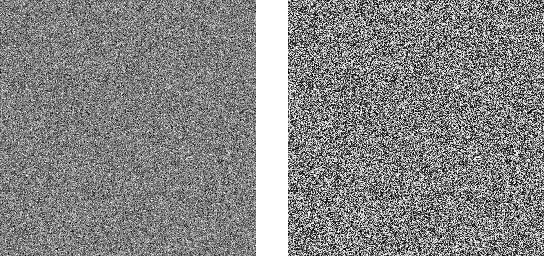

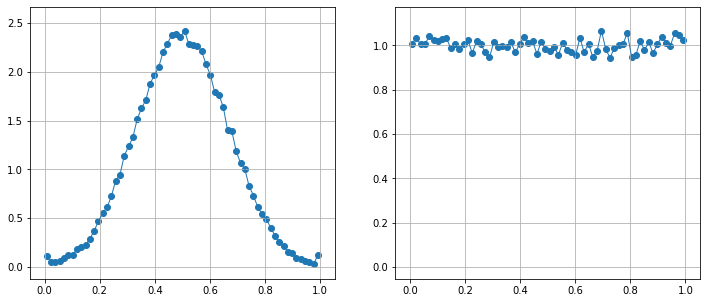

In [118]:
#
# Transport of distribtution (contd.) : normal <-> uniform
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import PIL.Image


def plot_hist(f, bins=2**5, n=3, range=None, ax=None, normalize=True):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]
    if normalize:
        hist = hist / (dx * np.prod(f.shape))

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1)


def to_pillow(a):
    a = a * 255
    a = a[..., np.newaxis] * [1, 1, 1] # Np(M, N) -> Np(M, N, 3)
    a = a.astype(np.uint8)
    a = PIL.Image.fromarray(a)
    return a


# TODO: making it ufunc seems difficult
def transport(y, F):
    # assert y in [0, 1]
    n = F.shape[0]
    i = np.floor(y * n).astype(np.int)
    probs = F[:, i] / np.sum(F[:, i])

    # sample bin based on probs
    r1 = np.random.random()
    j = list(r1 <= np.cumsum(probs)).index(True)

    # sample uniform within bin
    r2 = np.random.random()
    z = (j + r2) / n
    return z

transport_ufunc = np.vectorize(transport, otypes=[np.float], excluded=['F'])

def _():
    _, _, _, F = solve(n=2**5)
    N = 2**8
    a = np.random.normal(0.5, 1/6, size=(N, N))
    a = np.clip(a, 0, 0.999)
    b = transport_ufunc(a, F=F)
    c = np.concatenate([a, np.ones((N, 2**5)), b], axis=1)
    
    display(to_pillow(c))
    fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5))
    plot_hist(a, bins=2**6, range=[0, 1], ax=axes[0])
    plot_hist(b, bins=2**6, range=[0, 1], ax=axes[1])
    
_()

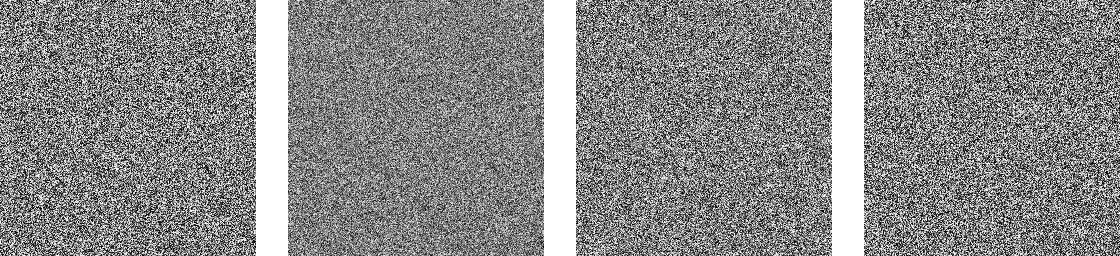

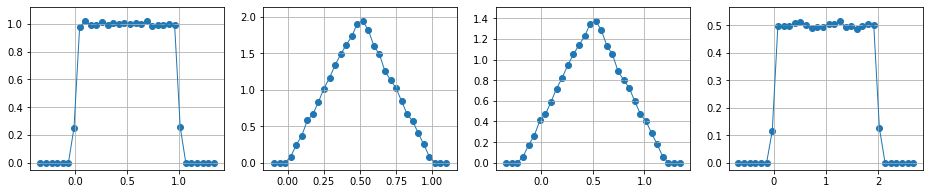

In [27]:
#
# Averaging uniform distribution
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import PIL.Image


# Histogram based on average and std
def plot_hist(f, bins=2**5, n=3, range=None, ax=None, normalize=True):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]
    if normalize:
        hist = hist / (dx * np.prod(f.shape))

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1)


def to_pillow(a):
    a = a * 255
    a = a[..., np.newaxis] * [1, 1, 1] # Np(M, N) -> Np(M, N, 3)
    a = a.astype(np.uint8)
    a = PIL.Image.fromarray(a)
    return a


def concat(ls, space=2**5, bg=1):
    H, _ = ls[0].shape
    s = np.ones((H, space)) * bg
    
    def gen():
        for i in range(len(ls)):
            if 0 < i: yield s
            yield ls[i]
            
    return np.concatenate(list(gen()), axis=1)


def _():
    # x : iid uniform [0, 1]
    N = 2**8
    x1 = np.random.random((N, N))
    x2 = np.random.random((N, N))
    mu = 0.5
    sigma = 1 / (np.sqrt(3) * 2)  # = int_{[-0.5, 0.5]} x^2

    # Average
    #   mu_f1 = mu
    #   sigma_f1 = sigma / np.sqrt(2)
    f1 = (x1 + x2) / 2

    # Average with variance scaling (but such scaling is clipped to [0, 1])
    #   mu_f2 = mu_f1 = mu
    #   sigma_f2 = alpha * sigma_f1 = sigma
    alpha = np.sqrt(2)
    f2 = alpha * (f1 - mu) + mu

    # Average with "surgery" (triangle distribution to uniform distribution mapping)
    g = 2 * f1
    g_mask = g < 1
    g1 = g**2
    g2 = 2 - (2 - g)**2
    f3 = np.where(g_mask, g1, g2)

    # Plotting
    display(to_pillow(concat([x1, f1, f2, f3])))
    fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 3))
    for ax, f in zip(axes, [x1, f1, f2, f3]):
        plot_hist(f, ax=ax)
    
_()

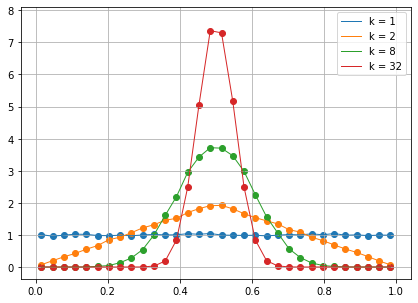

In [47]:
#
# Averaging uniform distribution (contd.)
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import PIL.Image
import ipywidgets as ipyw


# Histogram based on average and std
def plot_hist(f, bins=2**5, n=3, range=None, ax=None, normalize=True, label=''):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]
    if normalize:
        hist = hist / (dx * np.prod(f.shape))

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1, label=label)


def to_pillow(a):
    a = a * 255
    a = a[..., np.newaxis] * [1, 1, 1] # Np(M, N) -> Np(M, N, 3)
    a = a.astype(np.uint8)
    a = PIL.Image.fromarray(a)
    return a


def _(k=2, ax=False, image=True, label=''):
    N = 2**8
    x = np.random.random((N, N, k))
    y = np.sum(x, axis=-1) / k

    if image:
        display(to_pillow(y))
    plot_hist(y, range=[0, 1], ax=ax or None, label=label)


def _1():
    fig, ax = plt.subplots(figsize=(7,5))
    for k in [1, 2, 8, 32]:
        _(k=k, ax=ax, image=False, label=f"k = {k}")
    ax.grid()
    ax.legend()
    
    
# _()
_1()

# UI
# ipyw.interact(_, k=(1, 2**10, 1))

In [67]:
#
# Enumerating n bit integers by bit flip
#
# TODO:
# - Prove this really enumerates (I just conjectured from few small cases)
#   - "n+1 sequences" just repeats "n sequence" up and down
#   - (induction, parindromicity, etc...)
# - Is this related to "De Brujin sequence"? (those are by shift and append.)
#

def to_bits(x, n=32): # int -> str
    s = ''
    for i in range(n):
        if i > 0 and i % 4 == 0:
            s = ' ' + s
        b = (x >> i) & 1
        s = f"{b}" + s
    return s


def lowerest_bit(x, n=32):
    assert x != 0
    for i in range(n):
        if (x >> i) & 1:
            return i

def bit_flip_integers(n): # int -> generator(int)
    x = 0
    yield x
    for i in range(1, 2**n):
        k = lowerest_bit(i)
        x = x ^ (1 << k)
        yield x
        
def wellons(x):
    x ^= x >> 16
    x *= 0x7feb352d
    x ^= x >> 15
    x *= 0x846ca68b
    x ^= x >> 16
    return x

for x in bit_flip_integers(3):
    y = wellons(x)
    print(to_bits(x, n=4), "=>", to_bits(y))

0000 => 0000 0000 0000 0000 0000 0000 0000 0000
0001 => 1011 0111 1101 0010 1001 0000 1100 0000
0011 => 0011 1100 1001 0000 0001 1011 0010 1011
0010 => 0110 1111 1010 0101 0010 0001 1000 0001
0110 => 0111 1001 0010 0000 0011 0110 0101 0111
0111 => 0100 0011 0111 0100 1001 1000 0010 0100
0101 => 1001 0011 1110 0111 0111 1111 0000 1010
0100 => 0101 1011 1111 1010 1010 0001 0011 1011


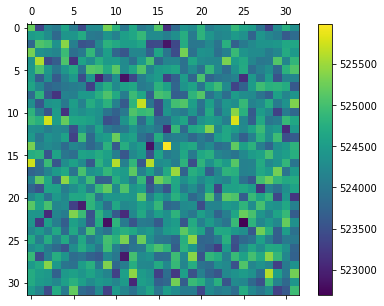

In [88]:
#
# Hash bias testing (cf. Chris Wellons https://nullprogram.com/blog/2018/07/31/)
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import numba


@numba.njit(["u4(u4)"])
def wellons(x):
    x ^= x >> 16
    x *= 0x7feb352d
    x ^= x >> 15
    x *= 0x846ca68b
    x ^= x >> 16
    return x


@numba.njit(["void(u4[:, :], u4, u4, u4)"])
def test_update(result, k, y, y_next):
    z = y ^ y_next
    for i in range(32):
        if (z >> i) & 1:
            result[k, i] += 1


@numba.njit(["u4[:, :](u8)"], parallel=True)
def test_wellons(num):
    result = np.zeros((32, 32), dtype=np.uint32)
    for k in numba.prange(32):
        for x in range(num):
            y = wellons(x)
            xx = x ^ (1 << k)
            yy = wellons(xx)
            test_update(result, k, y, yy)
    return result


@numba.njit(["u4[:, :](u8)"], parallel=True)
def test_wellons_random(num):
    result = np.zeros((32, 32), dtype=np.uint32)
    for k in numba.prange(32):
        for _ in range(num):
            x = np.random.randint(2**32)
            y = wellons(x)
            xx = x ^ (1 << k)
            yy = wellons(xx)
            test_update(result, k, y, yy)
    return result


def _(n):
    result = test_wellons_random(n)
    fig, ax = plt.subplots(figsize=(7, 5))
    cb = ax.matshow(result)
    fig.colorbar(cb)
    
_(2**20)

### Dithering

TODO: This still doesn't seems to capture "spatial distribution of error" much.

Analyze error diffusion as greedy strategy of optimization problem.

First we define a distance of two functions with the spirit of measuring
the difference of average radiance of fixed pixel size:

$
\begin{align}
L_{n}(f, g) &=
    \sum_{A : \text{$n \times n$ pixels}}
      \bigg| \sum_{x \in A} f(x) -  \sum_{x \in A} g(x) \bigg|
\end{align}
$

where 

- $f, g : [0, W) \times [0, H) \to [0, 1]$ represents picture's pixel value.


Also, defining the discretized pixel value domain

- $Discr(M) = \{\frac{0}{M}, \frac{1}{M}, ..., \frac{M}{M}\}$,

we consider the problem:

- Given $f$ $n$, and $M$, find $F: [0, W) \times [0, H) \to Discr(M)$ s.t. $\min L_{n}(f, F)$.


As a special case of $n = 1$, we can easily see that such $F$ is nothing but "closest rounding" as in:

- $F(x) = \text{round}(f(x), Discr(M))$.

From this point of view, "error diffusion" can be seens that it's a greedy approach of minimizing the average difference of certain size of area.

In [90]:
#
# Dithering (see above discussion)
#

# TODO:
# - [x] implement
#   - [x] take gamma compression into account
# - [-] example input
#   - [x] sample picture
#     - rgb
#     - only luminance
#   - [x] white noise
#     - analyze spectrum
#   - [-] color ramp
# - [-] analyze local/global error
#   - theoretical error bound?
# - [-] analyze "ordered dithering"
# - [-] analyze "stochastic dithering"
# - [-] some optimization for multi channel image?
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import PIL.Image
import numba

In [91]:
#
# Dithering (contd.) : 2D image spectrum visualization
#

def to_signed_heatmap(a):
    return np.stack([np.clip(a, 0, 1), np.clip(-a, 0, 1), np.zeros_like(a)]).T

def plot_fft(a, size=4):
    N, M = a.shape
    a_fft = np.fft.fft2(a) / np.sqrt(N * M)  # scale for L2 isometry
    a_fft = np.roll(a_fft, N // 2, axis=0)
    a_fft = np.roll(a_fft, M // 2, axis=1)    
    
    _, axes = plt.subplots(1, 2, figsize=(size * 2, size))
    ax = axes[0]
    ax.imshow(a, cmap='gray', vmin=0, vmax=1)
    ax = axes[1]
    ax.imshow(a_fft.real**2 + a_fft.imag**2, cmap='gray', vmin=0, vmax=1)
    # [square, real, imag]
    # _, axes = plt.subplots(1, 3, figsize=(5 * 3, 5))
    # ax = axes[0]
    # ax.imshow(np.clip(a_fft.real**2 + a_fft.imag**2, 0, 1), cmap='gray')
    # ax = axes[1]
    # ax.imshow(to_signed_heatmap(a_fft.real))
    # ax = axes[2]
    # ax.imshow(to_signed_heatmap(a_fft.imag))    
    return a_fft

In [92]:
#
# Dithering (contd.) : Deterministic dithering
#
# NOTE:
# - formally, optimization problem is to preserve average radiance of any arbitrary chosen patch of picture,
#   but "gamma" is taken into account for discretization for display radiance reproduction and human radiance perception
#

@numba.njit(["void(f8[:, :], i8, f8)"])
def floyd_steinberg(a, M, gamma=2.2):
    p1m, p10, p11, p01 = Np([3, 5, 1, 7]) / 16
    H, W = a.shape[:2]
    for y in range(1, H - 1):
        for x in range(1, W - 1):
            f = a[y+0, x+0]
            # Round to (i/M)^{1/gamma}
            F = np.fmax(f, 0)  # clip
            F = F**(1/gamma)
            F = np.round(F * M) / M
            F = F**(gamma)
            # Greedy/locally optimize error
            a[y+0, x+0] = F
            a[y+0, x+1] = a[y+0, x+1] + p01 * (f - F)
            a[y+1, x+0] = a[y+1, x+0] + p10 * (f - F)
            a[y+1, x+1] = a[y+1, x+1] + p11 * (f - F)
            a[y+1, x-1] = a[y+1, x+1] + p1m * (f - F)

# Above "floyd_steinberg" doesn't compile as it is, so here is the one with explicit rgb component loop
@numba.njit(["void(f8[:, :, :], i8, f8)"])
def floyd_steinberg3(a, M, gamma=2.2):
    p1m, p10, p11, p01 = Np([3, 5, 1, 7]) / 16
    H, W, Z = a.shape
    for y in range(1, H - 1):
        for x in range(1, W - 1):
            for z in range(Z):
                f = a[y+0, x+0, z]
                # Round to (i/M)^{1/gamma}
                F = np.fmax(f, 0)  # clip
                F = F**(1/gamma)
                F = np.round(F * M) / M
                F = F**(gamma)
                # Greedy/locally optimize error
                a[y+0, x+0, z] = F
                a[y+0, x+1, z] = a[y+0, x+1, z] + p01 * (f - F)
                a[y+1, x+0, z] = a[y+1, x+0, z] + p10 * (f - F)
                a[y+1, x+1, z] = a[y+1, x+1, z] + p11 * (f - F)
                a[y+1, x-1, z] = a[y+1, x+1, z] + p1m * (f - F)            

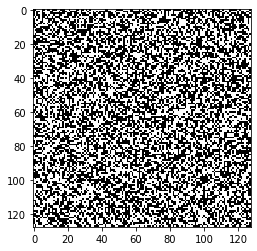

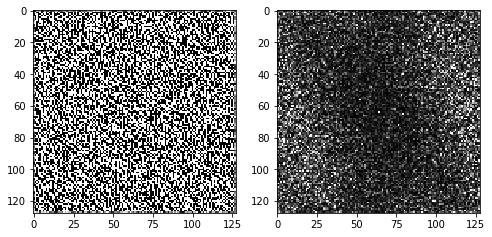

In [109]:
#
# Dithering (contd.) : dithering white noise and see its spectrum
#

def _():
    N = 2**7
    M = 1
    a = np.random.random((N, N))
    a_dithered = a.copy()
    floyd_steinberg(a_dithered, M, gamma=1)
    a_fft = plot_fft(a_dithered)
    return a_fft

a_fft = _()

In [115]:
#
# Dithering (contd.) : (memoized) image downloader
#

import functools

@functools.lru_cache(None)
def download_image(url):
    import requests, io
    resp = requests.get(url)
    image = PIL.Image.open(io.BytesIO(resp.content))
    return image

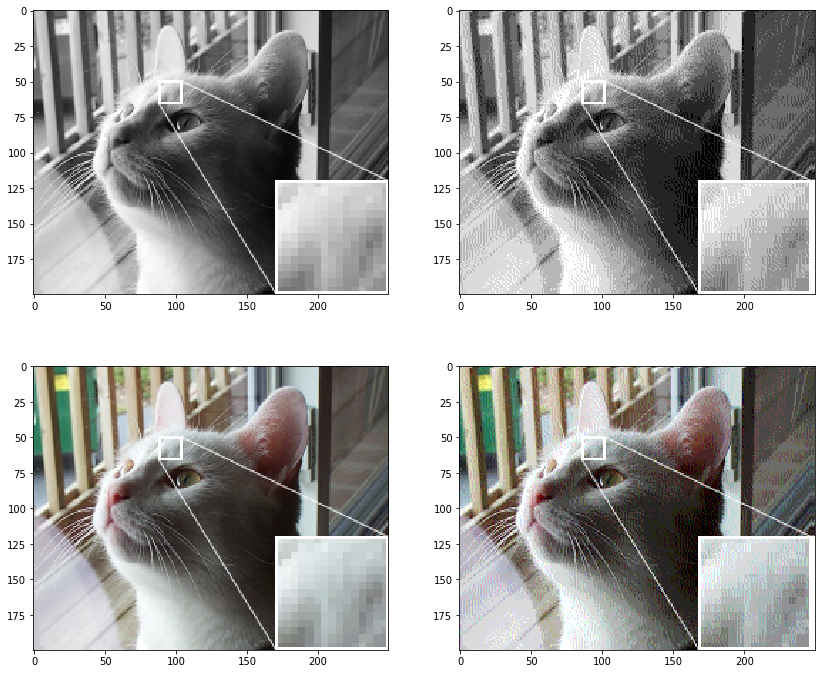

In [116]:
#
# Dithering (contd.)
#

def _1(M=7):
    # Example from https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering
    image = download_image('https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png')    
    a = Np(image)
    a = (a.astype(np.float) / 255)**2.2     # from sRGB
    lumi = a @ Np([0.2126, 0.7152, 0.0722]) # to luminance
    lumi_orig = lumi**(1/2.2)

    # Run dithering
    floyd_steinberg3(a, M, gamma=2.2)
    floyd_steinberg(lumi, M, gamma=2.2)

    a = np.clip(a, 0, 1)**(1/2.2)       # to sRGB
    lumi = np.clip(lumi, 0, 1)**(1/2.2)
    
    fig, axes = plt.subplots(2, 2, figsize=(7 * 2, 6 * 2))
    ax = axes[0, 0]
    ax.imshow(lumi_orig, cmap='gray')
    ax = axes[0, 1]
    ax.imshow(lumi, cmap='gray')
    
    ax = axes[1, 0]
    ax.imshow(image)
    ax = axes[1, 1]
    ax.imshow(a)
    
_1(M=7)

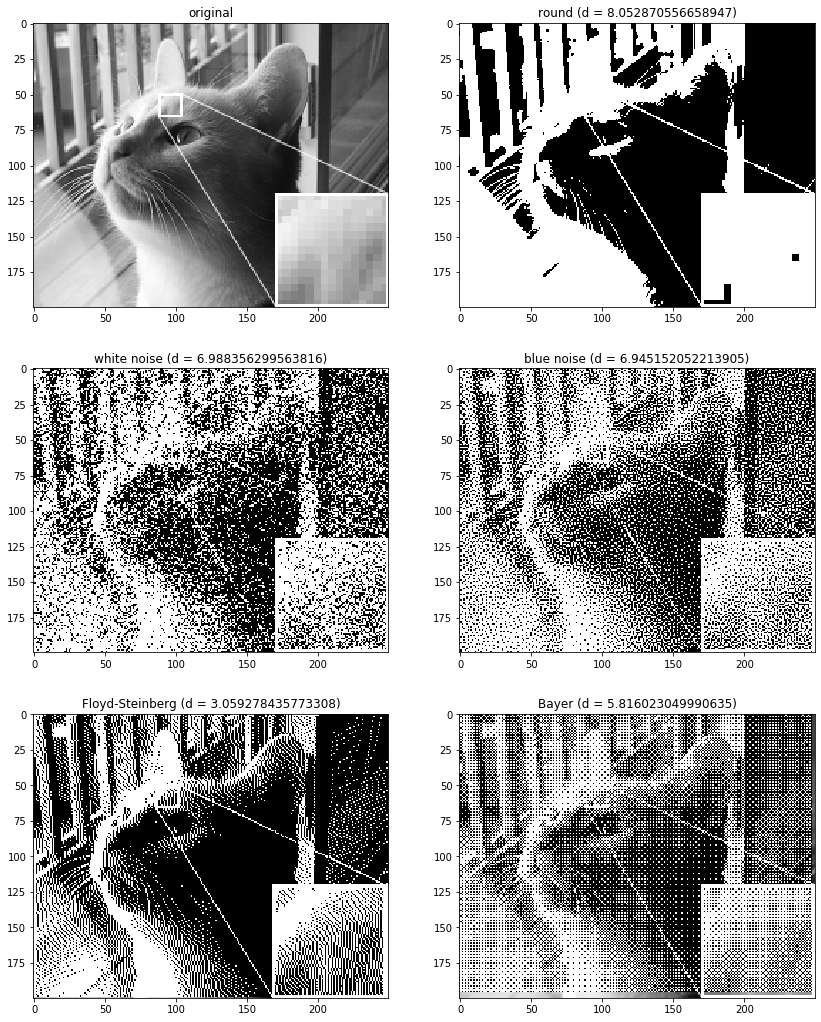

In [123]:
#
# Dithering (contd.) : random dithering
#
# TODO:
# - each pixel takes offset/threshold from noise and discretize
# - noise
#   - white noise
#   - blue noise
#    - [x] fft based generation
#    - [x] pseudo genration (cf. https://www.shadertoy.com/view/4sGSDd)
# - [x] measure a1, a2, a3 error
#

def to_luminance(srgb):
    return ((srgb.astype(np.float) / 255)**2.2) @ [0.2126, 0.7152, 0.0722]


def offset_dithering(f, g, M, gamma=2.2):
    # Round to (i/M)^{1/gamma}
    f = f**(1/gamma)
    f = M * f + g         # offset value by g on "gamma" dicretization
    f = np.round(f) / M
    f = np.clip(f, 0, 1)
    f = f**(gamma)
    return f

def diff(f, g, n):
    H, W = f.shape[:2]
    d = 0
    for y in range(H - n + 1):
        for x in range(W - n + 1):
            sum_f = 0
            sum_g = 0
            for j in range(n):
                for i in range(n):                
                    sum_f += f[y+j, x+i]
                    sum_g += g[y+j, x+i]                    
            d += np.abs(sum_f - sum_g)
    return d / (H * W)

def to_pillow(a, gamma=False):
    if gamma:
        a = a**(1/2.2)
    a_bytes = np.clip(a * 2**8, 0, 2**8 - 1).astype(np.uint8)
    return PIL.Image.fromarray(a_bytes)


def bayer_dithering(f):
    # assert f in sRGB
    f = f.copy()
    k = 4
    B = Np([
        1, 9, 3, 11,
        13, 5, 15, 7,
        4, 12, 2, 10,
        16, 8, 14, 6
    ]).reshape((k, k)) / 16

    h, w = f.shape[:2]
    for y in range(0, (h - 1) // k):
        for x in range(0, (w - 1) // k):
            i = k * y
            j = k * x
            f[i:i+k, j:j+k] = B < f[i:i+k, j:j+k]
    return f


def flatten(ls):
    def gen(xs):
        for x in xs:
            if hasattr(x, '__iter__'):
                yield from gen(x)
            else:
                yield x
    return list(gen(ls))


# Linear map [mu - n_std, mu + n_std] -> [0, 1] and clipping
def to_unit(f, n=3):
    mu = np.average(f)
    n_std = n * np.std(f)
    f = 0.5 + (f - mu) / (2 * n_std)
    return np.clip(f, 0, 1)


def blue_noise_shadertoy(shape):
    image = download_image('https://www.shadertoy.com/media/a/cb49c003b454385aa9975733aff4571c62182ccdda480aaba9a8d250014f00ec.png')
    H, W = shape
    a = Np(image)[:H, :W, 0]
    a = a.astype(np.float) / 255
    return a


def _2(M, name='cat'):
    urls = dict(
        cat='https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png',
        lenna='https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png')
    image = download_image(urls[name])
    lumi = lumi_orig = to_luminance(Np(image))

    # [white noise]
    white = np.random.random(lumi.shape[:2]) - 0.5  # in [-0.5, 0.5]
    # [blue noise]
    blue = blue_noise_shadertoy(lumi.shape[:2]) - 0.5

    lumi_round = offset_dithering(lumi, 0, M=M)
    lumi_white = offset_dithering(lumi, white, M=M)
    lumi_blue = offset_dithering(lumi, blue, M=M)
    lumi_floyd_steinberg = lumi.copy()
    floyd_steinberg(lumi_floyd_steinberg, M, gamma=2.2)
    lumi_floyd_steinberg = np.clip(lumi_floyd_steinberg, 0, 1)
    lumi_bayer = bayer_dithering(lumi**(1/2.2))

    num_axes = Np([3, 2])
    ax_size = Np([7, 6])
    fig, axes = plt.subplots(*num_axes, figsize=(np.flip(num_axes) * ax_size))
    axes = flatten(axes)
    ax = axes[0]
    ax.set(title='original')
    ax.imshow(lumi_orig**(1/2.2), cmap='gray', vmin=0, vmax=1)
    ax = axes[1]
    ax.set(title=f"round (d = {diff(lumi, lumi_round, 6)})")
    ax.imshow(lumi_round**(1/2.2), cmap='gray', vmin=0, vmax=1)    
    ax = axes[2]
    ax.set(title=f"white noise (d = {diff(lumi, lumi_white, 6)})")
    ax.imshow(lumi_white**(1/2.2), cmap='gray', vmin=0, vmax=1)
    ax = axes[3]
    ax.set(title=f"blue noise (d = {diff(lumi, lumi_blue, 6)})")    
    ax.imshow(lumi_blue**(1/2.2), cmap='gray', vmin=0, vmax=1)    
    ax = axes[4]
    ax.set(title=f"Floyd-Steinberg (d = {diff(lumi, lumi_floyd_steinberg, 6)})")
    ax.imshow(lumi_floyd_steinberg**(1/2.2), cmap='gray', vmin=0, vmax=1)    
    ax = axes[5]
    ax.set(title=f"Bayer (d = {diff(lumi, lumi_bayer**2.2, 6)})")
    ax.imshow(lumi_bayer, cmap='gray', vmin=0, vmax=1)        


_2(M=1, name='cat')

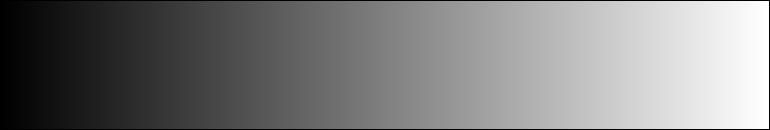

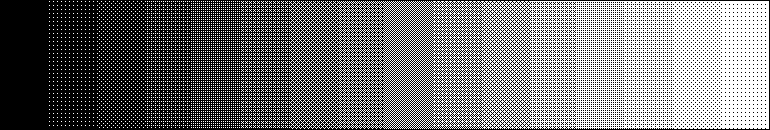

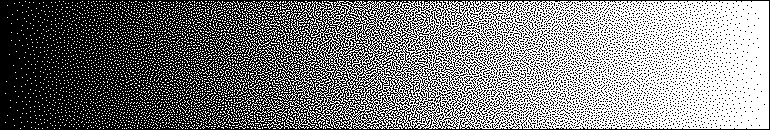

In [34]:
#
# Dithering (contd.) : example gray gradient
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import PIL.Image


def border(a, c=0):
    b = np.empty(Np(a.shape) + [2, 2], dtype=a.dtype)
    b[[0, -1], :] = b[:, [0, -1]] = c
    b[1:-1, 1:-1] = a
    return b


def bayer_dithering_uint8(f): # Np(M, N) -> Np(M, N)
    g = np.zeros_like(f)
    k = 4
    B = Np([
        1, 9, 3, 11,
        13, 5, 15, 7,
        4, 12, 2, 10,
        16, 8, 14, 6
    ]).reshape((k, k)) * 16

    h, w = f.shape[:2]
    for y in range(0, h // k):
        for x in range(0, w // k):
            i = k * y
            j = k * x
            ky, kx = g[i:i+k, j:j+k].shape
            g[i:i+k, j:j+k] = (B[:ky, :kx] <= f[i:i+k, j:j+k]) * (2**8 - 1)
    return g


def bluenoise_dithering_uint8(f):
    file = '../../python-shader-app/shaders/images/shadertoy/blue_noise_.png'
    H, W = f.shape[:2]
    a = Np(PIL.Image.open(file))[:H, :W, 0]
    return (a <= f) * (2**8 - 1)


def gray_ramp(M, K): # -> Np(M, K * 2**8)
    a = np.arange(2**8) # Np(N)
    a = Np([a] * M)  # Np(M, N)

    b = np.zeros(Np(a.shape) * [1, K], dtype=a.dtype)
    for i in range(K):
        b[:, i::K] = a[:, :]
    return b


def show_pillow(a):
    a = border(a)
    a = a[..., np.newaxis] * [1, 1, 1] # Np(M, N) -> Np(M, N, 3)
    a = a.astype(np.uint8)
    a = PIL.Image.fromarray(a)
    return a


def _(H=2**7, W=3):
    ramp = gray_ramp(2**7, W)
    display(show_pillow(ramp))
    display(show_pillow(bayer_dithering_uint8(ramp)))
    display(show_pillow(bluenoise_dithering_uint8(ramp)))    
    

_()

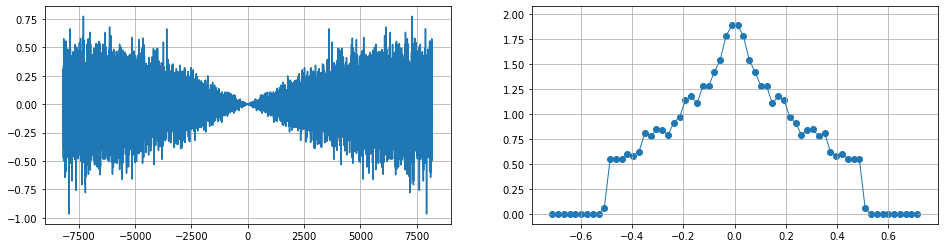

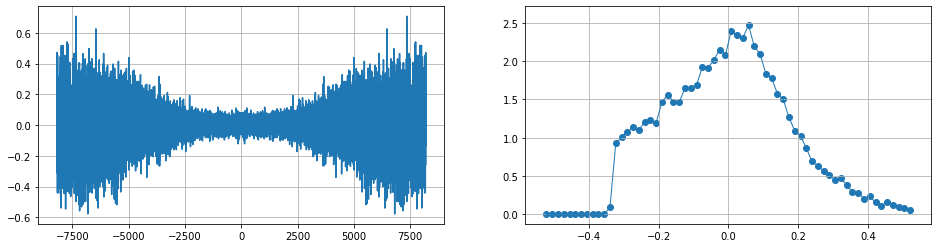

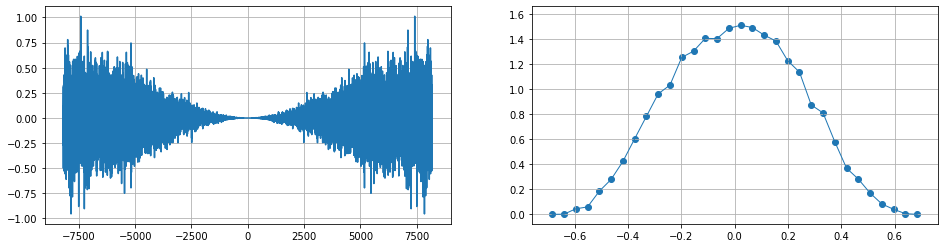

In [455]:
#
# Pseudo blue noise (cf. https://www.shadertoy.com/view/4sGSDd)
#

# TODO:
#  - [x] generalize to 2d case
#  - [x] analyze convolution (example `_2`)
#  - [x] analyze mu, var, covar of random variable
#

# Histogram based on average and std
def plot_hist(f, bins=2**5, n=3, range=None, ax=None, normalize=True):
    if range is None:
        range = np.average(f) + n * np.std(f) * Np([-1, 1])
    hist, bin_edges = np.histogram(f, bins=bins, range=range)
    dx = bin_edges[1] - bin_edges[0]
    if normalize:
        hist = hist / (dx * np.prod(f.shape))

    if ax is None:
        fig, ax = plt.subplots()
    ax.set(ylim=np.max(hist) * Np([-0.05, 1.1]))
    ax.grid()
    ax.scatter(bin_edges[:-1] + dx / 2, hist)
    ax.plot(bin_edges[:-1] + dx / 2, hist, linewidth=1)


def _0(N=2**14):
    # for each even-odd pair
    #   (z, w) = (u1 / (u1 + u2),  u2 / (u1 + u2))
    #
    # Noting z + w = 1 and symmetry
    #   E[z] = E[w] = E[z + w] / 2 = 1/2
    #
    # Noting z^2 + w^2 < (z + w)^2 = 1
    #   E[z^2] < 1/2
    #
    # Cov[z, w] = Cov[z, (1 - z)] = E[z (1 -z)] - E[z] E[1 - z]
    #           = E[z] - E[z^2] - E[z]^2
    #           = 1/4 - E[z^2]
    #           = E[z]^2 - E[z^2] = - Var[z]
    # Thus
    # Cov[(z, w)] = Var[z] (1, -1)
    #                      (-1, 1) 
    a = np.random.random(N)
    c = np.zeros_like(a)
    c[0::2] = (a[::2] + a[1::2])
    c[1::2] = (a[::2] + a[1::2])
    e = a / c - 0.5

    e_fft = np.fft.fft(e) / np.sqrt(N)
    e_fft = np.fft.fftshift(e_fft)

    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 4))
    ax = axes[0]
    ax.grid()
    ax.plot(np.arange(-N/2, N/2), e_fft.real)
    ax = axes[1]
    plot_hist(e, bins=2**6, ax=ax)


def _1(N=2**14):
    # for each u2, taking neighbor u1, u3
    #   u2 / (u1 + u2 + u3)
    a = np.random.random(N)
    c = a + np.roll(a, +1) + np.roll(a, -1)
    e = a / c
    e = e - 1/3

    e_fft = np.fft.fft(e) / np.sqrt(N)
    e_fft = np.fft.fftshift(e_fft)

    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 4))
    ax = axes[0]
    ax.grid()
    ax.plot(np.arange(-N/2, N/2), e_fft.real)
    ax = axes[1]
    plot_hist(e, bins=2**6, ax=ax)    


def _2(N=2**14):
    # for each u2, taking neighbor u1, u3    
    #   z = u2 - (u1 + u2 + u3) / 3
    #
    # It's easy to analyze E[z] and Var[z],
    #   E[z] = 2/3 * E[u2] - 1/3 * (E[u1] + E[u3]) = 0
    #   Var[z] = ((2/3)^2 + 2 * (1/3)^2) * Var[u] = 2/3 Var[u]
    #
    # Bound is clearly, |z| <= 2/3
    #
    # Also, it's easy to analyze frequency characteristics since this is convolution with
    #   g[-1], g[0], g[1] = -1, 2, -1
    # Since F[g * f] = F[g] F[f], it all about spectrum of F[g].
    #
    a = np.random.random(N)
    c = a + np.roll(a, +1) + np.roll(a, -1)
    e = a - c / 3

    e_fft = np.fft.fft(e) / np.sqrt(N)
    e_fft = np.fft.fftshift(e_fft)

    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 4))
    ax = axes[0]
    ax.grid()
    ax.plot(np.arange(-N/2, N/2), e_fft.real)
    ax = axes[1]
    plot_hist(e, ax=ax)


_0()
_1()
_2()

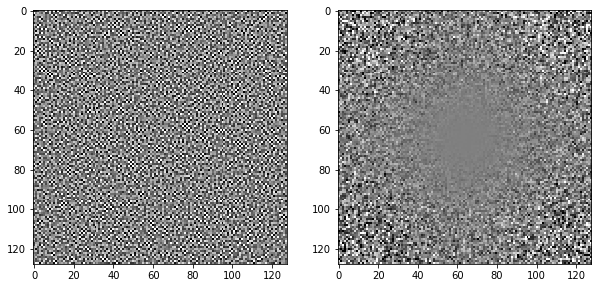

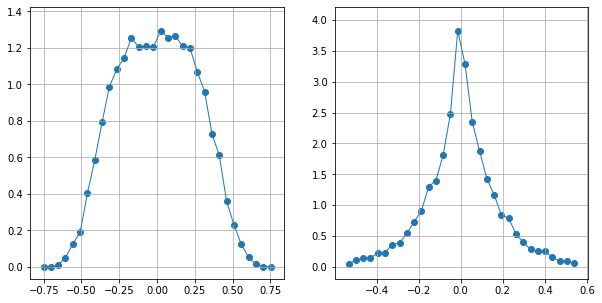

In [643]:
#
# Pseudo blue noise (contd.)
#
# - 2d version
#

def _0(N=2**7, hist=False):
    a = np.random.random((N, N))
    c = a + np.roll(a, -1, axis=0) + np.roll(a, -1, axis=1) + np.roll(a, (-1, -1), axis=(0, 1))
    c[1::2, 0::2] = c[0::2, 0::2]
    c[0::2, 1::2] = c[0::2, 0::2]
    c[1::2, 1::2] = c[0::2, 0::2]
    e = a / c - 1 / 4

    e_fft = np.fft.fft2(e) / N
    e_fft = np.roll(e_fft, (N // 2, N //2), axis=(0, 1))

    fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))
    if hist:
        ax = axes[0]
        plot_hist(e, ax=ax)
        ax = axes[1]
        plot_hist(e_fft.real, ax=ax)        
    else:
        ax = axes[0]
        ax.imshow(e, vmin=-1/3, vmax=1/3, cmap='gray')
        ax = axes[1]        
        ax.imshow(e_fft.real, vmin=-1/3, vmax=1/3, cmap='gray')


def _1(N=2**7, hist=False):
    a = np.random.random((N, N))
    c = a + np.roll(a, +1, axis=0) + np.roll(a, -1, axis=0) \
          + np.roll(a, +1, axis=1) + np.roll(a, -1, axis=1)
    e = a / c
    e = e - 1/5

    e_fft = np.fft.fft2(e) / N
    e_fft = np.roll(e_fft, (N // 2, N //2), axis=(0, 1))

    fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))
    if hist:
        ax = axes[0]
        plot_hist(e, ax=ax)
        ax = axes[1]
        plot_hist(e_fft.real, ax=ax)
    else:
        ax = axes[0]
        ax.imshow(e, vmin=-1/5, vmax=1/5, cmap='gray')
        ax = axes[1]
        ax.imshow(e_fft.real, vmin=-1/5, vmax=1/5, cmap='gray')    


def _2(N=2**7, hist=False):
    a = np.random.random((N, N))
    
    def apply(a):
        c = a + np.roll(a, +1, axis=0) + np.roll(a, -1, axis=0) \
              + np.roll(a, +1, axis=1) + np.roll(a, -1, axis=1)
        e = a - c / 5
        return e
    
    e = apply(a)

    e_fft = np.fft.fft2(e) / N
    e_fft = np.roll(e_fft, (N // 2, N //2), axis=(0, 1))

    fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))
    if hist:
        ax = axes[0]
        plot_hist(e, ax=ax)
        ax = axes[1]
        plot_hist(e_fft.real, ax=ax)
    else:
        ax = axes[0]
        ax.imshow(e, vmin=-0.5, vmax=0.5, cmap='gray')
        ax = axes[1]
        ax.imshow(e_fft.imag, vmin=-0.5, vmax=0.5, cmap='gray')

# _0()
# _1()
_2()
_2(hist=True)

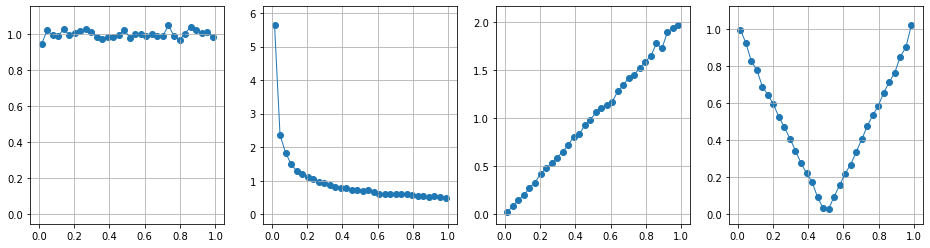

In [546]:
#
# Push-forward uniform distribution
#

def _():
    N = 2**17
    a = np.random.random(N)
    b = np.sign(a - 0.5) * np.abs(a - 0.5)**(1/2) + 0.5 

    fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 4))
    plot_hist(a, range=[0, 1], ax=axes[0])
    plot_hist(a**(2), range=[0, 1], ax=axes[1])
    plot_hist(a**(1/2), range=[0, 1], ax=axes[2])
    plot_hist(b, range=[0, 1], ax=axes[3])    

_()

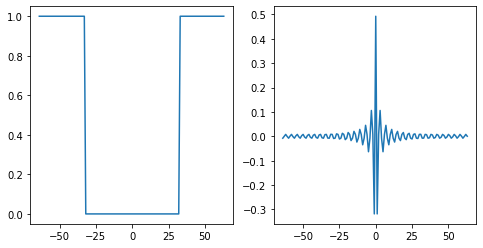

In [549]:
#
# Box Low pass filter
#

def _0():
    N = 2**7
    g = np.ones(N)
    g = g * (np.abs(np.arange(N) - N//2) < N//4)
    g_ifft = np.fft.ifft(g)
    
    fig, axes = plt.subplots(1, 2, figsize=(4 * 2, 4))
    ax = axes[0]
    ax.plot(np.arange(-N//2, N//2), np.fft.fftshift(g))
    ax = axes[1]
    ax.plot(np.arange(-N//2, N//2), np.fft.fftshift(g_ifft.real))
    
_0()

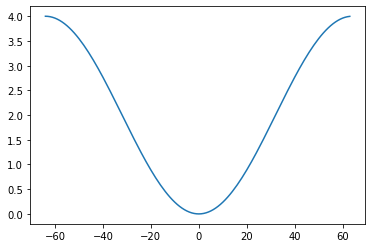

In [530]:
#
# Low pass filter kernels
#

def _0():
    N = 2**7
    k = np.zeros(N)
    k[-1], k[0], k[1] = Np([-1, 2, -1])

    k_fft = np.fft.fft(k)
    k_fft = np.fft.fftshift(k_fft)

    plt.plot(np.arange(-N/2, N/2), k_fft.real)

    
def _1():
    N = 2**7
    k = np.zeros(N)
    k[-2], k[-1], k[0], k[1], k[2] = Np([1, -3.5, 5, -3.5, 1])

    k_fft = np.fft.fft(k)
    k_fft = np.fft.fftshift(k_fft)

    plt.plot(np.arange(-N/2, N/2), k_fft.real)

_0()
# _1()

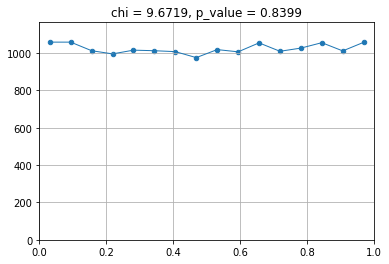

In [79]:
#
# Pearson's chi-squared test
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt


def gamma(s):
    assert (2.0 * s).is_integer(), f"Not implemented s = {s}"
    if s == 1:
        return 1
    if s == 0.5:
        return np.sqrt(np.pi)
    ss = s - 1
    return ss * gamma(ss)


def erfcx_tmp(b):
    # Def. tmp(b) = (int_{x > b} exp(-x^2)) / exp(-b^2)  (so, erfc(b) = (2 / sqrt(pi)) tmp(b) * exp(-b^2))
    # Here, I have (2/3)-pade approximation of it (cf. pade_approximation_erf.ipynb)
    assert 0 <= b
    q  = [28.89119882, 14.30231234,  3.64735179,  0.        ]
    p  = [32.60022686, 52.92384812, 31.23353657,  6.84303508]
    bb = b ** np.arange(4)
    return sum(q * bb) / sum(p * bb)
    

def gamma_imcomplete_right(b, s):
    # Def. int_[b, oo] x^{s - 1} exp(-x)
    #
    # Go recursively by parts integration until s = 1, 0.5 then
    #   when s = 1, it's exp(-b)
    #   when s = 0.5, it reduces to error function: int_[sqrt(b) < x] 2 exp(-x^2)
    #
    assert 0.5 <= s and (2.0 * s).is_integer(), f"Not implemented s = {s}"
    assert 0 <= b
    if s == 1:
        return np.exp(-b)
    if s == 0.5:
        return 2 * erfcx_tmp(np.sqrt(b)) * np.exp(-b)
    ss = s - 1
    return b**ss * np.exp(-b) + ss * gamma_imcomplete_right(b, ss)


def cdf_gamma(b, s):
    # int_{[0, x]} gamma(x)
    return 1 - (gamma_imcomplete_right(b, s) / gamma(s))


def cdf_chi_squared(b, k):
    if b == 0: return 0
    return cdf_gamma(b / 2, k / 2)


def histogram(x, bin_edges): # float(N...), float(k+1) -> int(k)
    l = len(bin_edges)
    cum_hist = np.zeros(l, dtype=np.int)
    for i in range(l):
        cum_hist[i] = np.sum(bin_edges[i] <= x)
    return cum_hist[:-1] - cum_hist[1:]


def pearson_chi(num_samples, num_bins, rng=np.random):
    k = num_bins
    N = num_samples
    bin_edges = np.arange(k + 1) / k
    x = rng.random(N)
    hist = histogram(x, bin_edges)
    mu = N / k                      # hypothesize uniformity
    chi = np.sum((hist - mu)**2 / mu)
    return chi, hist, bin_edges


def _0(s=0.5):
    # Compare my imcomplete gamma vs scipy's gdtr
    import scipy.special as sps
    bb = np.linspace(0, 4)
    y = sps.gdtr(1, s, bb)
    z = [ cdf_gamma(b, s) for b in bb ]

    fig, ax = plt.subplots()
    ax.grid()
    ax.plot(bb, y, label="scipy")
    ax.plot(bb, z, label="mine")
    ax.legend()


def _1(num_samples, num_bins, rng=np.random):
    chi, hist, bin_edges = pearson_chi(num_samples, num_bins, rng=rng)
    p_value = 1 - cdf_chi_squared(chi, k=num_bins - 1)
    x_plot = bin_edges[:-1] + 1 / (2 * num_bins)
    y_plot = hist

    fig, ax = plt.subplots()
    ax.set(title=f"chi = {chi:.4f}, p_value = {p_value:.4f}",
           xlim=[0, 1], ylim=[0, max(y_plot) * 1.1])
    ax.grid()
    ax.scatter(x_plot, y_plot, s=20)
    ax.plot(x_plot, y_plot, linewidth=1)


_1(2**14, 2**4)

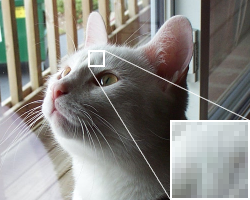

In [14]:
download_image('https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png')

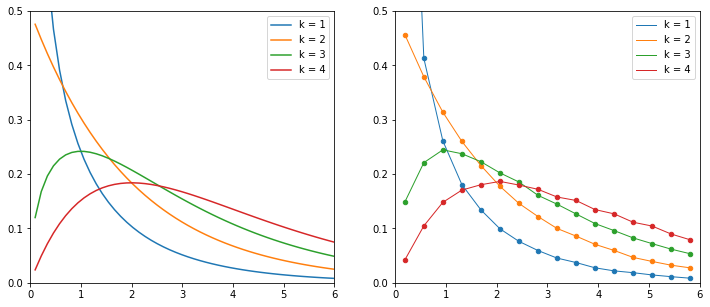

In [48]:
#
# Chi-squared distribution
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt

def gamma(s):
    assert type(s) == int or (2 * s).is_integer(), f"Not implemented s = {s}"
    if s == 1:
        return 1
    if s == 0.5:
        return np.sqrt(np.pi)
    ss = s - 1
    return ss * gamma(ss)

def pdf_gamma(x, s):
    return (1 / gamma(s)) * x**(s - 1) * np.exp(-x)

def pdf_chi_squared(x, k=1):
    return pdf_gamma(x / 2, k / 2) / 2


# Pdf analytically
def _0(k=1, ax=False):
    x = np.linspace(0.1, 6)
    y = pdf_chi_squared(x, k=k)

    if ax is False:
        fig, ax = plt.subplots(figsize=(6, 5))
    ax.set(xlim=[0, 6], ylim=[0, 0.5])
    ax.grid()
    ax.plot(x, y, label=f"k = {k}")


# Simulate Chi-squared distribution
def _1(k=2, ax=False):
    N = 2**17
    hist_bins = 2**4
    hist_range = [0, 6]
    dx = (hist_range[1] - hist_range[0]) / hist_bins
    y = np.zeros(N)
    for _ in range(k):
        y += np.random.normal(size=N) ** 2
    h, x = np.histogram(y, bins=hist_bins, range=hist_range)
    x_plot = x[:-1] + 0.5 * dx  # center of bin interval
    y_plot = h / (N * dx)       # get unit right

    if ax is False:
        fig, ax = plt.subplots(figsize=(6, 5))
    ax.set(xlim=[0, 6], ylim=[0, 0.5])    
    ax.grid()
    ax.scatter(x_plot, y_plot, s=20)
    ax.plot(   x_plot, y_plot, linewidth=1, label=f"k = {k}")    


def _():
    fig, axes = plt.subplots(1, 2, figsize=(6 + 6, 5))
    for k in range(1, 5):
        _0(k=k, ax=axes[0])
        _1(k=k, ax=axes[1])
    axes[0].legend()
    axes[1].legend()


_()

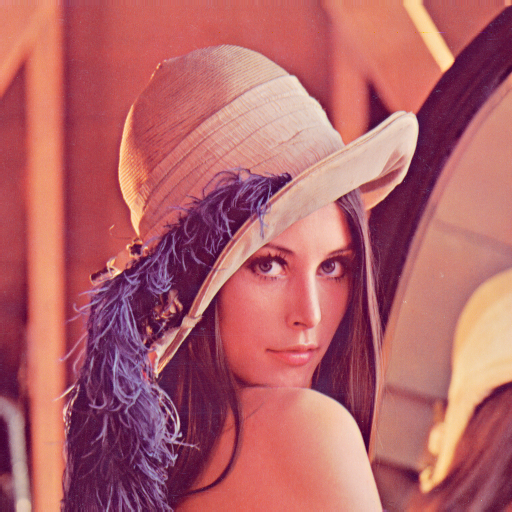

In [18]:
download_image('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png')

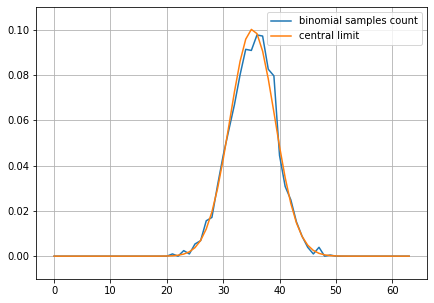

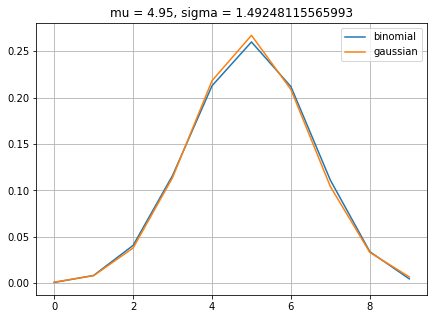

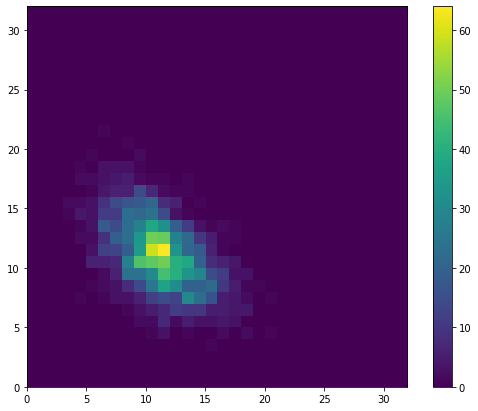

In [53]:
#
# Central limit theorem visualization
#
# - Binomial    -> Gaussian
# - Multinomial -> Multi-var. Gaussian
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def sample_bernoulli(p, k=1, rng=np.random): # float -> float(k)
    return (1 - p) < rng.random(k)


def sample_binomial(N, p, k=1, rng=np.random): # int, float -> int(k)
    # N Bernoulli trial at once and sum it
    bs = sample_bernoulli(p, k=k * N, rng=rng)
    return np.sum(bs.reshape((k, N)), axis=1)


def sample_multinomial2(N, p0, p1, k=1, rng=np.random): # int, float, float -> int(k, 3)
    # convolution of {0, 1, 2} distribution
    # P(0) = p0
    # P(1) = p1
    # P(2) = 1 - p0 - p1
    u = rng.random(N * k).reshape((k, N))
    b0  = u <= p0
    b01 = u <= (p0 + p1)
    n0 = np.sum(b0, axis=-1)
    n01 = np.sum(b01, axis=-1) 
    n1 = n01 - n0
    n2 = N - n01
    return np.stack([n0, n1, n2]).T


def binomial_coeff(N): # uint -> uint(N + 1)
    def zero_to_one(x):
        return np.where(x == 0, 1, x)
    a = np.arange(N + 1, dtype=np.uint64)
    n = zero_to_one(a)
    fact_n = np.cumprod(n)
    fact_N = np.prod(n)
    m = zero_to_one(N - a)
    return fact_N // (fact_n * np.flip(fact_n))


def unit_gaussian(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(- x**2 / 2)


# Binomial distribution by sampling
def _0(k=2**10, p=0.5, N=64, seed=1):
    # force seed
    np.random.seed(seed)  
    
    # sample and count by bins
    bins = np.zeros(N)
    ns = sample_binomial(N, p, k=k)
    for n in ns:
        bins[n] += 1
    bins /= k
        
    x = np.arange(N)
    mu = N * p
    sigma = np.sqrt(N * p * (1 - p))
    central_limit = unit_gaussian((x - mu) / sigma) / sigma
    
    # plotting
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set(ylim=[-0.01, 0.11])
    ax.grid()
    ax.plot(x, bins, label=f"binomial samples count")
    ax.plot(x, central_limit, label=f"central limit")
    ax.legend()


# Binomial distribution analytically (for N > 20, `binomial_coeff` overflows)
def _1(p=0.5, N=16):
    n = np.arange(N + 1)
    binom = binomial_coeff(N) * (p**n) * ((1 - p)**(N - n))

    mu = N * p
    sigma = np.sqrt(N * p * (1 - p))
    g = unit_gaussian((n - mu) / sigma) / sigma

    # plotting
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set(title=f"mu = {mu}, sigma = {sigma}")
    ax.grid()
    ax.plot(n, binom, label=f"binomial")
    ax.plot(n, g, label=f"gaussian")
    ax.legend()


# Multinomial distribution by sampling
def _2(k=2**11, N=32, p0=1/3, p1=1/3, seed=1, gaussian=False):
    # force seed
    np.random.seed(seed)

    # sample and count by bins
    bins = np.zeros((N, N))
    n012s = sample_multinomial2(N, p0, p1, k=k) # int(k, 3)
    for n0, n1, n2 in n012s:
        bins[n1, n0] += 1
    
    # gaussian with same mean/covariance (TODO: covariance seems wrong?)
    mu = N * Np([p0, p1])
    cov = N * (np.diag([p0, p1]) - Np([[p0], [p1]]) * Np([p0, p1]))
    a = np.arange(N)
    x, y = np.meshgrid(a, a)
    def apply_quadratic(x, y, A):
        return A[0, 0] * x**2 + \
               A[0, 1] * 2 * x * y + \
               A[1, 1] * y**2
    inv, det = np.linalg.inv, np.linalg.det
    g = unit_gaussian(apply_quadratic(x - mu[0], y - mu[1], inv(cov))) / np.sqrt(det(cov))

    # plotting
    fig, ax = plt.subplots(figsize=(7 + 2, 7))
    if gaussian:
        cb = ax.matshow(g, origin='lower', extent=[0, N, 0, N])        
    else:
        cb = ax.matshow(bins, origin='lower', extent=[0, N, 0, N])
    ax.xaxis.tick_bottom()
    fig.colorbar(cb)


_0(p=0.55, k=2**11)
_1(p=0.55, N=9)
_2()

# ipyw.interact(_0, k=(0, 2**20, 2**10), p=(0, 1, 0.05), N=(2, 2**8, 2**4))
# ipyw.interact(_1)
# ipyw.interact(_2, k=(0, 2**20, 2**10), N=(2, 2**8, 2**4))

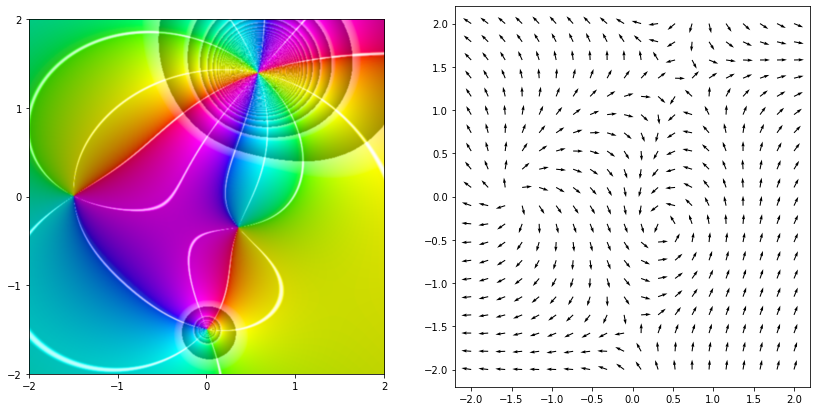

In [64]:
#
# Domain coloring (visulizatoin of meromorphic function) 
#
# NOTE:
# - this is not really useful for visualizing 2d vector flow since
#   hue isoline contour (i.e. same angle of flow) isn't not physically meaningful compared streamline etc...
# - but lightness gradient represents size of flow so it might be nice by directly combining with matplotlib's
#   quiver plotting.
#
# TODO:
# - can we extend this idea to some quaternion field or something?
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def matshow_with_axis(ax, x, y, f):
    def minmax(t):
        return np.min(t), np.max(t)
    ax.matshow(f, origin='lower', extent=[*minmax(x), *minmax(y)], interpolation='bicubic')
    ax.xaxis.tick_bottom()


def hue_lightness_to_rgb_ufunc(h, l):
    rgb = plt.cm.hsv(h)[..., :3] # float(..., 3)
    l = Np(l)[..., np.newaxis]   # float(..., 1)
    b  = l < 0.5
    t1 = l / 0.5
    t2 = (l - 0.5) / 0.5
    return b * t1 * rgb + (1 - b) * ((1 - t2) * rgb + t2)


def smoothstep(t):
    t = np.clip(t, 0, 1)
    return (-2 * t + 3) * t * t


def matshow_domain_coloring(
        ax, x, y, u, v, gamma=True,
        modulus_contour=(1, 0.2, 0.6),
        argument_contour=(5, 0.01, 0.5)):
    argu = np.arctan2(v, u)
    modu = np.sqrt(u**2 + v**2)
    hue   = np.mod(argu, 2 * np.pi) / (2 * np.pi)
    
    # modulus contour
    _mod, _min, _max = modulus_contour
    light = np.mod(modu, _mod) * ((_max  - _min) / _mod) + _min
    
    # argument contour
    num, width, weight = argument_contour
    for b in np.linspace(0, 1, num + 1, endpoint=False):
        d = np.fmin(np.abs(hue - b), 1 - np.abs(hue - b))
        light += weight * (1 - smoothstep(d / (width / 2)))
        
    light = np.clip(light, 0, 1)
    rgb = hue_lightness_to_rgb_ufunc(hue, light)
    if gamma:
        rgb = rgb**(1/2.2)
    matshow_with_axis(ax, x, y, rgb)


def _0(quiver=False):
    def get(num):
        t = np.linspace(-2, 2, num=num)
        x, y = np.meshgrid(t, t)
        z = x + 1j * y
        fz = np.sin(z)
        c1 = 0.5 * np.exp(1j * np.pi * -1 / 4)
        c2 = 1.5 * np.exp(1j * np.pi)
        c3 = 1.5 * np.exp(1j * np.pi * 3 / 8)
        c4 = 1.5 * np.exp(1j * np.pi * -1 / 2)
        fz = ((z - c1) * (z - c2)) / ((z - c3)**2 * (z - c4))
        u, v = np.real(fz), np.imag(fz)
        return x, y, u, v
    
    x, y, u, v = get(2**9)
    _, axes = plt.subplots(1, 2, figsize=(14, 7))    
    ax = axes[0]
    matshow_domain_coloring(ax, x, y, u, v)

    if quiver:
        x, y, u, v = get(20) 
        m = np.sqrt(u**2 + v**2)
        u, v = u / m, v /m
        ax = axes[1]
        ax.quiver(x, y, u, v)

_0(quiver=True)

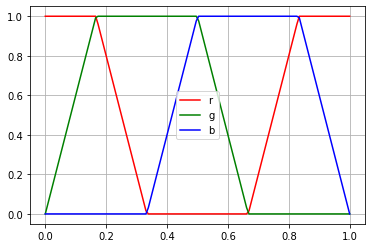

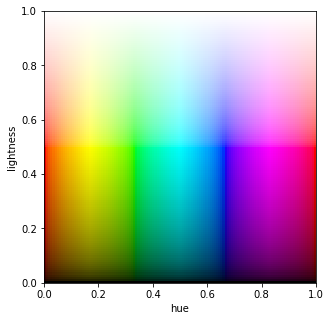

In [25]:
#
# Hue/Lightness to RGB
#  
# NOTE:
# - Geometrically,
#   at  lightness = 0.5, hue sweeps cube edges which don't pass (0, 0, 0) and (1, 1, 1).
#   for lightness > 0.5, such hue sweep path's point is interpolated with (1, 1, 1).
#   for lightness < 0.5,  ...                           interpolated with (0, 0, 0).
#
# TODO:
# - transform rgb based on sRGB luminance axis (0.2126, 0.7152, 0.0722)
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def bump_ufunc(t, position, height, slope, period=None):
    # @param
    #   t        : float(...) <- broadcastable pair
    #   position : float(...) <- 
    #   height   : float
    #   slope    : float
    #   period   : float
    if period is None:
        d = np.abs(t - position)
    else:
        tp = np.mod(t - position, period)
        d = np.fmin(tp, period - tp)
    return height - slope * d


# It turned out it can be constructed by clipping periodic linear bump
def hue_to_rgb_ufunc(h): # float(N..) -> float(N.., 3)
    h = h[..., np.newaxis]                   # float(N.., 1)
    v = (Np([0, 1, 2]) / 3)                  # float(3)
    bump = bump_ufunc(h, v, 2, 6, period=1)  # float(N.., 3)
    return np.clip(bump, 0, 1)


def hue_lightness_to_rgb_ufunc(h, l):
    # @param:
    #   h, l : float(...) broadcastable pair
    # @return:
    #   rgb  : float(..., 3)
    rgb = hue_to_rgb_ufunc(h)  # float(..., 3)
    l = Np(l)[..., np.newaxis] # float(..., 1)
    b = l < 0.5  # don't use as mask in order to make "broadcast friendly"    

    # This formulation shows it's actually bilinear interp
    t1 = l / 0.5
    t2 = (l - 0.5) / 0.5
    result  = b       * ((1 - t1) * 0   + t1 * rgb)
    result += (1 - b) * ((1 - t2) * rgb + t2 * 1  )
    return result


# Plot hue to rgb
def _0(l=0.5):
    h = np.linspace(0, 1, num=2**7)
    rgb = hue_lightness_to_rgb_ufunc(h, l)

    _, ax = plt.subplots(figsize=(6, 4))
    ax.set(ylim=Np([0, 1]) + 0.05 * Np([-1, 1]))
    ax.grid()
    ax.plot(h, rgb[..., 0], color='r', label='r')
    ax.plot(h, rgb[..., 1], color='g', label='g')
    ax.plot(h, rgb[..., 2], color='b', label='b')
    ax.legend()

# Shade 2d plane by hue/lightness
def _1(gamma=True):
    t = np.linspace(0, 1, num=2**7)        # float(N)
    h, l = np.meshgrid(t, t)               # h, l: float(N, N)
    rgb = hue_lightness_to_rgb_ufunc(h, l) # float(N, N, 3)
    if gamma:
        rgb = rgb**(1/2.2)
    
    _, ax = plt.subplots(figsize=(5, 5))
    ax.set(xlabel='hue', ylabel='lightness')
    ax.imshow(rgb, origin='lower', extent=[0, 1, 0, 1])

    
# Compare matplotlib's builtin colormap
def _2(i=0, diff=True):
    h = np.linspace(0, 1, num=2**7)
    rgb = hue_to_rgb_ufunc(h)
    rgb_cm = plt.cm.hsv(h)
    
    _, ax = plt.subplots(figsize=(6, 4))
    ax.grid()
    if diff:
        ax.set(ylim=0.1 * Np([-1, 1]), title=f"rgb_cm[{i}] - rgb[{i}]")
        ax.plot(t, plt.cm.hsv(t)[:, i] - hue_to_rgb_ufunc(t)[:, i])
    else:
        ax.set(ylim=Np([0, 1]) + 0.05 * Np([-1, 1]))
        ax.plot(t, plt.cm.hsv(t)[:, i])
        ax.plot(t, hue_to_rgb_ufunc(t)[:, i])    


_0()
_1(gamma=True)

# UI
# ipyw.interact(_0, l=(0, 1, 0.05))
# ipyw.interact(_1)
# ipyw.interact(_2, i=(0, 2, 1))

### Surface gravity wave

From Euler's equation with various assumptions/approximations, we are led to:

$
\begin{align}
& \Delta \phi = 0 \\
& \partial_y \phi = 0                &\text{(at $y = -h$)} \\
& \partial_y \phi = \partial_t \eta  &\text{(at $y = 0$)} \\
& \partial_t \phi = - g \eta         &\text{(at $y = 0$)}
\end{align}
$

where

- $\eta(x, t)$ : surface displacement
- $u(x, y, t) = \nabla \phi(x, y, t)$ :
    time-dependent curl-free velocity vector field $u$ defined by gradient of a potential $\phi$.

Then, by looking for a single wave separable solution as in:

$
\begin{align}
\eta(x, t)    &= \exp(i(k x - w t)) \\
\phi(x, y, t) &= Y(y) \eta(x, t),
\end{align}
$

we easily find a condition to have such a solution:

$
\begin{align}
\omega^2 &= g k \tanh(h k) \\
\phi(x, y, t) &= \frac{g}{\omega} \frac{\cosh(k (y + h))}{\cosh(k h)} (-i \eta(x, t)). \\
\end{align}
$

Or taking their real component, we get:

$
\begin{align}
\eta(x, t) &= \cos(k x - w t) \\
\phi(x, y, t) &= \frac{g}{\omega} \frac{\cosh(k (y + h))}{\cosh(k h)} \sin(k x - w t). \\
\end{align}
$

From $\omega^2 = g k \tanh(h k)$ (aka. dispersion relation),
we get a phase velocity $v_p$ as in:

$
\begin{align}
v_p &= \frac{\omega}{k} = \sqrt{\frac{g}{k} \tanh(h k)} \\
    &= \sqrt{\frac{g \lambda}{2 \pi} \tanh(\frac{2 \pi h}{\lambda})}
\end{align}
$

Here, for two qualitatively distinct cases,

- when $4 \lesssim h k$, we have $1 - \tanh(h k) \lesssim 10^{-3}$,
  thus $v_p \approx \sqrt{\frac{g}{k}} \approx \sqrt{\frac{g \lambda}{2 \pi}}$,
  
- on $hk \downarrow 0$, we have $\tanh(h k) \approx h k$,
  thus $v_p \approx \sqrt{g h}$.

Regarding a group velocity $v_g$, we note that:

$
\begin{align}
\frac{v_g}{v_p}
    &= \frac{\partial_k \omega}{(\frac{\omega}{k})} \\
    &= k \partial_k \log \omega \\
    &= k \partial_k \log (g k \tanh(h k))^{\frac{1}{2}} \\
    &= k \frac{1}{2} (0 + \frac{1}{k} + \frac{1}{\tanh(h k)} \frac{1}{\cosh^2(h k)}) \\
    &= \frac{1}{2} (1 + \frac{h k}{\sinh(h k) \cosh(h k)})
\end{align}
$

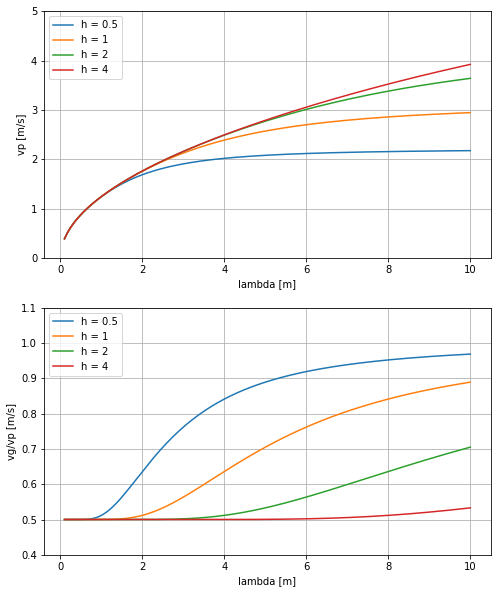

In [58]:
#
# Surface gravity wave plotting (formula from above)
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def _0(h=1, g=9.8, axes=False):
    lam = np.linspace(0.1, 10, num=2**7)
    k = 2 * np.pi / lam
    vp = np.sqrt((g / k) * np.tanh(h * k))
    vg_over_vp = 0.5 * (1 + (h * k) / (np.sinh(h * k) * np.cosh(h * k)))

    if axes is False:
        _, axes = plt.subplots(2, 1, figsize=Np([8, 4]) + Np([0, 6]))
    ax = axes[0]
    ax.set(ylim=[0, 5], xlabel='lambda [m]', ylabel='vp [m/s]')
    ax.grid()
    ax.plot(lam, vp, label=f"h = {h}")    
    ax.legend()
    
    ax = axes[1]
    ax.set(ylim=[0.4, 1.1], xlabel='lambda [m]', ylabel='vg/vp [m/s]')
    ax.grid()
    ax.plot(lam, vg_over_vp, label=f"h = {h}")
    ax.legend()    


def _1():
    fig, axes = plt.subplots(2, 1, figsize=Np([8, 4]) + Np([0, 6]))
    _0(h=0.5, axes=axes)        
    _0(h=1, axes=axes)
    _0(h=2, axes=axes)
    _0(h=4, axes=axes)
    for ax in axes: ax.grid()


_1()

# UI mode
# ipyw.interact(_0, h=(0.1, 8, 0.1))

### Surface gravity wave (contd.)

Here, we analyze a vector field $u(x, y, t) = \nabla \phi(x, y, t)$.

From above discussion, we have:

$
\begin{align}
\eta(x, t)    &= \exp(i(k x - w t)) \\
\phi(x, y, t) &= Y(y) \eta(x, t)  \\
Y(y) &= -i \frac{g}{\omega} \frac{\cosh(k (y + h))}{\cosh(k h)}
\end{align}
$

By noting $Y'(y) = k \tanh(k (y + h)) Y(y)$, we obtain:

$
\begin{align}
u(x, y, t)
  &= \nabla \phi(x, y, t) \\
  &= 
    \begin{pmatrix}
       Y(y)  \cdot \partial_x \eta(x, t) \\
       Y'(y) \cdot \eta(x t)
    \end{pmatrix} \\
  &= 
    \begin{pmatrix}
       Y(y) \cdot i k \eta(x, t) \\
       k \tanh(k(y + h)) Y(y) \cdot \eta(x, t)
    \end{pmatrix} \\
  &= 
    \begin{pmatrix}
       i \\
       \tanh(k(y + h)) 
    \end{pmatrix} k \, Y(y) \, \eta(x, t)
\end{align}
$

By taking real component, we find:

$
\begin{align}
\text{Re}(u)
  &=
    \begin{pmatrix}
       - \text{Im}(\phi(x, y, t)) \\
       \tanh(k(y + h)) \cdot \text{Re}(\phi(x, y, t))
    \end{pmatrix} \\
  &= k |Y(y)|
    \begin{pmatrix}
       \cos(x, t) \\
       \tanh(k(y + h)) \cdot \sin(x, t)
    \end{pmatrix} \\
  &= k |Y(y)|
    \begin{pmatrix}
        1 & 0 \\
        0 & \tanh(k(y + h))
    \end{pmatrix}
    \text{R}_{k x - w t}
    \begin{pmatrix}
       1 \\
       0
    \end{pmatrix},
\end{align}
$

where $R_{\theta}$ denotes 2d rotation matrix with $\theta$ radian.

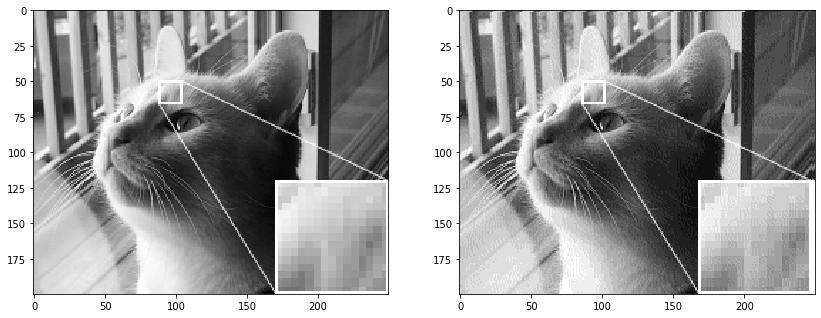

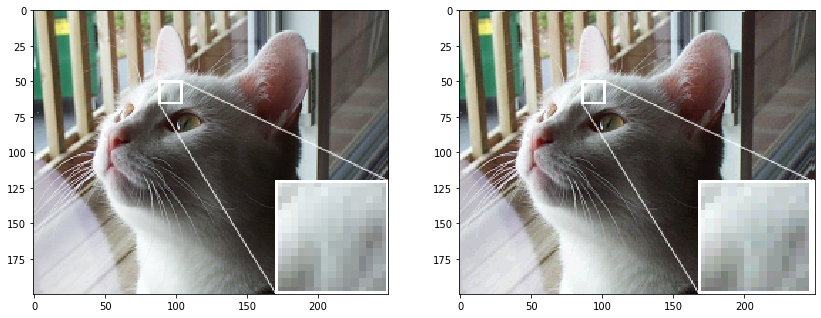

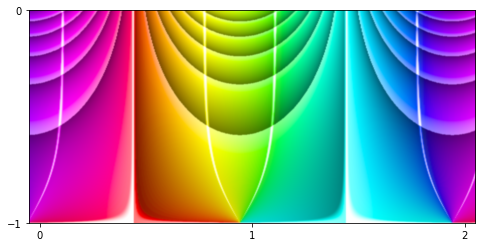

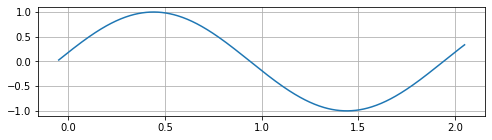

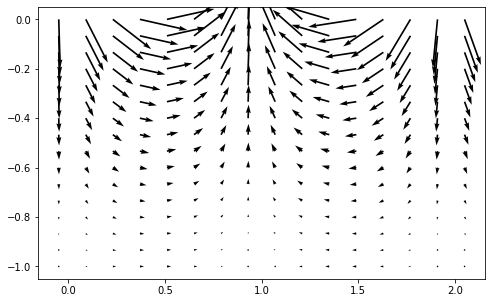

In [80]:
#
# Surface gravity wave (contd.)
#
# - [x] visualize vector field potential \phi
#   - visualize together with \eta (surface displacement)
#   - lightness contour by \phi
#   - hue by grad(\phi)
#   - matplotlib's quiver (streamlines)
# - time dependent field animation
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw


def matshow_with_axis(ax, x, y, f):
    def minmax(t):
        return np.min(t), np.max(t)
    cb = ax.matshow(f, origin='lower', extent=[*minmax(x), *minmax(y)], interpolation='bicubic')
    ax.xaxis.tick_bottom()
    return cb


def hue_lightness_to_rgb_ufunc(h, l):
    rgb = plt.cm.hsv(h)[..., :3] # float(..., 3)
    l = Np(l)[..., np.newaxis]   # float(..., 1)
    b  = l < 0.5
    t1 = l / 0.5
    t2 = (l - 0.5) / 0.5
    return b * t1 * rgb + (1 - b) * ((1 - t2) * rgb + t2)


def smoothstep(t):
    t = np.clip(t, 0, 1)
    return (-2 * t + 3) * t * t


def matshow_domain_coloring(
        ax, x, y, u, v, modulus=None, gamma=True,
        modulus_contour=(1, 0.1, 0.6),
        argument_contour=(5, 0.01, 0.5)):
    arg = np.arctan2(v, u)
    hue = np.mod(arg, 2 * np.pi) / (2 * np.pi)
    if modulus is None:
        modulus = np.sqrt(u**2 + v**2)
    
    # modulus contour
    _mod, _min, _max = modulus_contour
    light = np.mod(modulus, _mod) * ((_max  - _min) / _mod) + _min
    
    # argument contour
    num, width, weight = argument_contour
    for b in np.linspace(0, 1, num + 1, endpoint=False):
        d = np.fmin(np.abs(hue - b), 1 - np.abs(hue - b))
        light += weight * (1 - smoothstep(d / (width / 2)))
        
    light = np.clip(light, 0, 1)
    rgb = hue_lightness_to_rgb_ufunc(hue, light)
    if gamma:
        rgb = rgb**(1/2.2)
    matshow_with_axis(ax, x, y, rgb)


def _0(lam=2, h=1, g=9.8, t=0,
       domain_coloring=True, phi_as_modulus=True,
       surface=True,
       quiver=True, quiver_normalize=False):
    k = 2 * np.pi / lam
    w = np.sqrt(g * k * np.tanh(h * k))
    vp = w / k
    
    def compute(num):
        x = np.linspace(*(0.05 * Np([-1, 1]) + [0, lam]), num=num)
        y = np.linspace(-h, 0, num=num)
        x, y = np.meshgrid(x, y)

        # As complex wave
        # eta = np.exp(1j * (k * x - w * t))
        # phi = (g / w) * (np.cosh(k * (y + h)) / np.cosh(k * h)) * -1j * eta

        # As real part
        co = np.cos(k * x - w * t)
        si = np.sin(k * x - w * t)
        eta = co
        absY = (g / w) * (np.cosh(k * (y + h)) / np.cosh(k * h))
        phi = absY * si

        # Vector field
        ux = k * absY * 1                    * co
        uy = k * absY * np.tanh(k * (y + h)) * si
        
        return x, y, ux, uy, phi, eta
    
    x, y, ux, uy, phi, eta = compute(2**9)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    if domain_coloring:
        if phi_as_modulus:
            matshow_domain_coloring(ax, x, y, ux, uy, modulus_contour=(0.3, 0.1, 0.6), modulus=phi)
        else:
            matshow_domain_coloring(ax, x, y, ux, uy, modulus_contour=(0.8, 0.1, 0.6))
    else:
        cb = matshow_with_axis(ax, x, y, phi)
        fig.colorbar(cb)
        
    if surface:
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.plot(x[0], eta[0])
        ax.grid()

    if quiver:
        fig, ax = plt.subplots(figsize=(8, 5))
        x, y, ux, uy, phi, eta = compute(2**4)
        if quiver_normalize:
            m = np.sqrt(ux**2 + uy**2)
            ux, uy = ux / m, uy /m
        ax.quiver(x, y, ux, uy)


_0(t=0.25)

# UI
# ipyw.interact(_0, lam=(0.1, 4, 0.1), h=(0.1, 4, 0.1), t=(0, 4, 0.1))

In [26]:
#
# Fourier transform (numerically)
#
# - (continuous) Fourier transform
# - Fourier series
#   - [x] finite sample and bounded support approx of continous Fourier transform
# - Discreter Fourier transform
#   - [x] Riermann sum approx of Fourier series
# - [x] Higher dimention
#   - DFT Convention
#   - Complexity
#

### Fourier series vs Descrete Fourier transform

Define Fourier series for $X$-period function as below:

$
\begin{align}
F_S[f](k) \equiv \int_{-\frac{X}{2}}^{\frac{X}{2}} \sqrt{\frac{1}{X}} \exp(-i k \frac{2 \pi}{X} x) f(x).
\end{align}
$

Define Discrete Fourier transform $\mathbb{C}^N \to \mathbb{C}^N$ (where even $N$) as below:

$
\begin{align}
F_D[v](k) \equiv \sum_{m} \exp(-i (2 \pi k) \frac{m}{N}) \, v_m,
\end{align}
$

where we write vector indices $m, k \in [-\frac{N}{2}, \frac{N}{2} - 1]$.

Here, we consider DFT as Riemann sum approximation of Fourier series. \
Taking finite samples as $x_m = \frac{X}{N} m$ and $f_m = f(\frac{X}{N} x) \,$  (i.e. $\Delta_x = \frac{X}{N}$), we have:

$
\begin{align}
F_S[f](k)
    &\approx \sqrt{\frac{1}{X}} \Delta_x \sum_{m} \exp(-i k \frac{2 \pi}{X} \frac{X}{N} m) f(x_m) \\
    &=       \sqrt{\frac{1}{X}} \Delta_x F_D[(f_m)](k) \\
    &=       \frac{\sqrt{X}}{N} F_D[(f_m)](k)    
\end{align}
$

### Fourier tranform vs Fourier series

For a function $f$ with $\text{supp}(f) \in [-\frac{X}{2}, \frac{X}{2}]$,
Fourier series gives Fourier transformation with spacing $\Delta k = \frac{2 \pi}{X}$:

$
\begin{align}
F[f](k)
    &\equiv \sqrt{\frac{1}{2 \pi}} \int_{\mathbb{R}} \exp(-ikx) f(x) \\
    &=      \sqrt{\frac{X}{2 \pi}} F_S[f](\frac{2 \pi}{X} k)
\end{align}
$

Combining with DFT-Fourier-series approximation, we obtain:

$
\begin{align}
F[f](k)
    &=      \sqrt{\frac{X}{2 \pi}} F_S[f](\frac{2 \pi}{X} k)  \\
    &=      \sqrt{\frac{1}{2 \pi}} \Delta_x F_D[(f_m)](\frac{2 \pi}{X} k)
\end{align}
$

In [2]:
#
# Discrete Fourier transform as an approx of (continuous) Fourier transform
# 
# - Follow scipy's DFT convention
#   - Input domain range and order 
#   - Output positive/negative frequency entries
#   - "N" factor only on inverse DFT
# - Correct scaling 
# - Correct translation to centerize localized function
# - Limitation
#   - Relationship of x-domain and k-domain
#     - [-X/2, X/2]   =>  [-N/2 * 2pi/X, N/2 * 2pi/X]
#         N                 N 
#         dx = X / N        dk = 2pi / X
#     - So, in order to obtain finer k resolution, X has to be "unnecessarily" large.
#       i.e. trivial zero function value domain has to be considered.
#     - Increasing N doesn't affect k resolution.
#     - TODO: Is it possible to implement to specialized version of DFT to support this use case?
#

import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import scipy


def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)


def _(X=16, N=2**8):
    # Define parameters
    xlim = [-X / 2,  X / 2]
    xlim_wrap = [0, X]
    Nh = N // 2
    dx = X / N

    # Example input (gaussian)
    x = np.linspace(*xlim, num=N, endpoint=False)
    fx = unit_gaussian_ufunc(x)

    # Pass "wrapped" version to DFT as domain convention
    x_wrap = np.linspace(*xlim_wrap, num=N, endpoint=False)
    fx_wrap = np.concatenate([fx[Nh:], fx[:Nh]])
    Fk_tmp = scipy.fft(fx_wrap)
    Fk_tmp = np.concatenate([Fk_tmp[Nh:], Fk_tmp[:Nh]])

    # Scale k-domain and value to use them as approximation of "continuous" Fourier transform
    k_tmp = np.arange(-Nh, Nh)
    dk = 2 * np.pi / X
    k = dk * k_tmp
    Fk = dx * np.sqrt(1 / (2 * np.pi)) * Fk_tmp

    # Plotting
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].set(xlim=xlim, title=f"")
    axes[0].plot(x, fx)
    axes[1].set(xlim=xlim, title=f"dk = {dk:.4f}")
    axes[1].plot(k, np.real(Fk))


_(X=8)
_(X=32)

### Derivation of FFT recursion

Define:

$
\begin{align}
F_{[0, N)}(k)
    &\equiv \sum_{m} \exp(-i (2 \pi k) \frac{m}{N}) f_m
\end{align}
$

where indices for $k, m \in \mathbb{Z}_N$. Indeed, neither taking $k + N$ or $m + N$ won't change the result.

When $N = 2M$, we notice that;

$
\begin{align}
F_{[0, 2M)}(k)
    &= \sum_{m \in [0, 2M)} exp(-i (2 \pi k) \frac{m}{2M}) f_m  \\
    &= \sum_{m \in [0, M)}
        exp(-i (2 \pi k) \frac{2m}{2M}) f_{2m} \; + \;
        exp(-i (2 \pi k) \frac{2m + 1}{2M}) f_{2m + 1}          \\
    &= \sum_{m \in [0, M)}
        exp(-i (2 \pi k) \frac{m}{M}) f_{2m} \; + \;
        exp(-i \frac{\pi k}{M}) \; exp(-i (2 \pi k) \frac{m}{M}) f_{2m + 1}          \\ 
    &= F_{2 [0, M)}(k) \; + \; exp(-i \frac{\pi k}{M}) \; F_{2 [0, M) + 1}(k).
\end{align}
$

Now, using $k = k + M \in \mathbb{Z}_M$, we have:

$
\begin{align}
F_{[0, 2M)}(k + M)
    &= F_{2 [0, M)}(k + M) \; + \; exp(-i \frac{\pi (k + M)}{M}) \; F_{2 [0, M) + 1}(k + M) \\
    &= F_{2 [0, M)}(k) \; - \; exp(-i \frac{\pi k}{M}) \; F_{2 [0, M) + 1}(k)
\end{align}
$

In [3]:
import numpy as np;  Np = np.array
import matplotlib.pyplot as plt
import numba

@numba.njit(['void(c16[:], c16[:], i8)'])
def fft_impl(f, F, N):
    # @param
    #   f : complex(N)
    #   F : complex(N) (out)
    #   N : int
    if N == 1:
        F[0] = f[0]
        return
    
    f_ev = f[0::2]
    f_od = f[1::2]
    Nh = N // 2
    F_ev = F[:Nh]  # reuse this "return space" as children's "return space" as well
    F_od = F[Nh:] 
    fft_impl(f_ev, F_ev, Nh)
    fft_impl(f_od, F_od , Nh)
    k = np.arange(Nh)
    e = np.exp(-1j * np.pi * k / Nh)
    front = F_ev + e * F_od
    back  = F_ev - e * F_od
    F[:Nh], F[Nh:] = front, back


def fft(f):
    # complex(N) -> complex(N)
    N = len(f)
    assert float.is_integer(np.log2(N))

    F = np.empty_like(f, dtype=np.complex)
    fft_impl(f, F, N)
    return F


def test_fft(perf=False):
    N = 2**12
    a = np.random.random(N)
    b = np.random.random(N)
    c = a + 1j * b
    assert np.allclose(fft(c), np.fft.fft(c))
    if perf:
        print(f":: fft N = {N}")
        %timeit -n 10 fft(c)
        %timeit -n 10 np.fft.fft(c)

test_fft()    

In [4]:
def fft2_impl(f, F, G, N1, N2):
    # f : complex(N1, N2)
    # F : complex(N1, N2)  (out) (work space)
    # G : complex(N1, N2)  (out)
    for n in range(N1):
        fft_impl(f[n, :], F[n, :], N2)
    for n in range(N2):
        fft_impl(F[:, n], G[:, n], N1)


def fft2(f):
    # complex(N1, N2) -> complex(N1, N2)
    N1, N2 = f.shape
    assert float.is_integer(np.log2(N1))
    assert float.is_integer(np.log2(N2))    

    F = np.empty_like(f, dtype=np.complex)
    G = np.empty_like(f, dtype=np.complex)                 
    fft2_impl(f, F, G, N1, N2)
    return G


def test_fft2(perf=False):
    N = 2**8
    a = np.random.random((N, N))
    b = np.random.random((N, N))
    c = a + 1j * b
    assert np.allclose(fft2(c), np.fft.fft2(c))
    if perf:
        print(f":: fft2 (N1, N2) = ({N}, {N})")
        %timeit -n 3 fft2(c)
        %timeit -n 3 np.fft.fft2(c)

test_fft2()

In [5]:
test_fft(perf=True)
print()
test_fft2(perf=True)

:: fft N = 4096
3.07 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
97.5 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

:: fft2 (N1, N2) = (256, 256)
86.3 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.53 ms ± 60 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


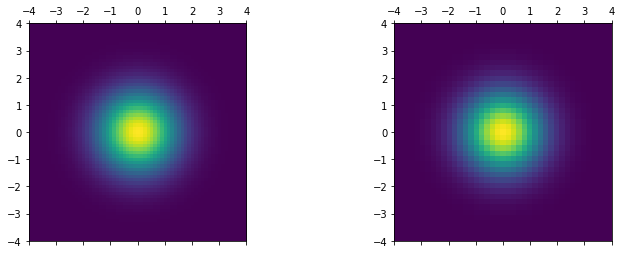

In [6]:
def unit_gaussian_ufunc(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x*x/2)

def make_extent(xlim, ylim, dx, dy):
    x_ext = Np(xlim) + 0.5 * dx * Np([-1, 1])
    y_ext = Np(ylim) + 0.5 * dy * Np([-1, 1])
    return [*x_ext, *y_ext]


def tmp_matshow(ax, t, f, cmap=None):
    dt = t[1] - t[0]
    lim = [t[0], t[-1]]
    extent = make_extent(lim, lim, dt, dt)
    ax.xaxis.tick_bottom()
    cb = ax.matshow(f, origin='lower', extent=extent, cmap=cmap)
    return cb


def _():
    X = 32
    N = 2**8

    plot_lim = [-4, 4]
    xlim = [-X / 2, X / 2]
    Nh = N // 2
    dx = X / N

    # Input gaussian
    t = np.linspace(*xlim, num=N, endpoint=False)
    x, y = np.meshgrid(t, t)
    f = unit_gaussian_ufunc(x) * unit_gaussian_ufunc(y)

    # DFT
    f_wrap = np.roll(f, (N // 2, N // 2), axis=(0, 1))
    F_tmp = fft2(f_wrap + 0j)
    F_tmp = np.real(F_tmp)

    # Translate and scale to use DFT as approximation of Fourier transform
    dk = 2 * np.pi / X
    k = dk * np.arange(-Nh, Nh)
    F_tmp = dx * dx / (2 * np.pi) * F_tmp
    F_tmp = np.roll(F_tmp, (N // 2, N // 2), axis=(0, 1))
    F = F_tmp

    # Plotting
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    cb = tmp_matshow(axes[0], t, f)
    axes[0].set(xlim=plot_lim, ylim=plot_lim)

    cb = tmp_matshow(axes[1], k, F, cmap=cb.cmap)
    axes[1].set(xlim=plot_lim, ylim=plot_lim)
    
_()